In [ ]:
"""test marker representation on sample sequences"""

In [1]:
import os
import sys
import mmh3
import pickle
import random
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
# define data paths
data_dir = '/ccb/salz4-4/markus/markraken/data'

seq_pickle_path = os.path.join(data_dir, 'DB.pkl')
HPC_pickle_path = os.path.join(data_dir, 'DB_HPC.pkl')
hashtable_path = os.path.join(data_dir, 'index.pkl')

In [3]:
# load data
with open(seq_pickle_path, 'rb') as f:
    seq_list = pickle.load(f)

with open(HPC_pickle_path, 'rb') as f:
    HPC_list = pickle.load(f)

In [17]:
n_markers = 16000 # number of markers to use for representation of sequence as markers, Shasta default = 8000
marker_length = 10 # length of marker sequence, Shasta default = 10

# randomly select marker set without replacement, surprisingly complex to vectorize, works fast enough like this
random.seed(2019)
marker_set = set()
while len(marker_set) < n_markers:
    marker = [random.sample('ATCG', 1)[0]]
    for i in range(marker_length-1):
        nucs = {'A', 'T', 'C', 'G'}
        nucs.remove(marker[-1])
        marker.append(random.sample(nucs, 1)[0])
    marker_set.add(''.join(marker))

marker_list = list(marker_set)

In [18]:
# TODO sample while considering reverse complement to ensure easy searches regardless of strand

In [19]:
# extract markers from homopolymer compressed sequence
# TODO temprorary code here, marker finding can definitely be improved a lot
def markerize(HPC_seq):
    marker_seq = []
    for i in range(len(HPC_seq)):
        subseq = HPC_seq[i:i+marker_length]
        try:
            idx = marker_list.index(subseq)
            marker_seq.append(idx)
        except:
            pass
        
    return marker_seq

foo = markerize(HPC_list[0])
print(len(HPC_list[0]))
print(len(foo))

5976
1213


In [20]:
n_threads = 30

# markerize all HPC seqs
p = mp.Pool(n_threads)
markerized_list = p.map(markerize, HPC_list)
p.close()
p.join()

In [21]:
# convert list to tuple to allow hashing
markerized_chrlist = [''.join([chr(s) for s in x]) for x in markerized_list]

In [22]:
%%time
# extract marKmers (short kmers with much larger alphabet) from marker sequences
# marKmer uniqueness is roughly equivalent to a normal kmer of length = marKmer_length*marker_length
# e.g. with marker length 10, marKmer 3 ~ kmer 30
marKmer_length = 3
hash_seed = 2019

marKmer_hashtable = dict()
for i, m in enumerate(markerized_chrlist): # i is stand-in for true taxid, TODO handle taxid with LCA
    marKmer_set = set()
    for j in range(len(m)):
        subseq = m[j:j+marKmer_length] # this might be slow, TODO check if this slices or copies
        marKmer_set.add(subseq) # adding to set is O(1)
        
    hashlist = [mmh3.hash(x, hash_seed) for x in list(marKmer_set)]
    tmp_dict = dict(zip(hashlist, [i]*len(hashlist)))
    marKmer_hashtable.update(tmp_dict)

CPU times: user 21.9 s, sys: 1.14 s, total: 23 s
Wall time: 23 s


In [23]:
# %%time
# # extract marKmers (short kmers with much larger alphabet) from marker sequences
# # marKmer uniqueness is roughly equivalent to a normal kmer of length = marKmer_length*marker_length
# # e.g. with marker length 10, marKmer 3 ~ kmer 30
# marKmer_length = 3
# hash_seed = 2019

# marKmer_hashtable = dict()
# for i, m in enumerate(markerized_chrlist): # i is stand-in for true taxid, TODO handle taxid with LCA
#     marKmer_set = set()
#     for i in range(len(m)):
#         subseq = m[i:i+marKmer_length] # this might be slow, TODO check if this slices or copies
#         marKmer_set.add(subseq) # adding to set is O(1)
#     for m in marKmer_set:
#         h = mmh3.hash(m, hash_seed)
#         marKmer_hashtable.update({h:i}) # TODO check if adding to dict is O(1)

In [26]:
# # save index
# with open(hashtable_path, 'wb') as f:
#     pickle.dump(marKmer_hashtable, f)

In [33]:
# examine compression ratio
singleseq = ''.join(seq_list)
print(len(pickle.dumps(marKmer_hashtable))/1e9, 'gigabytes for index') # guaranteed correct or overestimate of object size
# print(len(pickle.dumps(singleseq))/1e9, 'Gbp of sequence')
print(len(singleseq)/1e9, 'Gbp of sequence')

0.007801361 gigabytes for index
0.116762833 Gbp of sequence


In [28]:
def markerize_chr(HPC_seq):
    marker_seq = []
    for i in range(len(HPC_seq)):
        subseq = HPC_seq[i:i+marker_length]
        try:
            idx = marker_list.index(subseq)
            marker_seq.append(chr(idx))
        except:
            pass
        
    return marker_seq

In [29]:
def marKmerize(marker_chrlist, marK):
    marKmer_set = set()
    for i in range(len(marker_chrlist)-marK):
        marKmer = ''.join(marker_chrlist[i:i+marK])
        marKmer_set.add(marKmer)
    return marKmer_set

In [30]:
i = 1
offset = 0
readlength = 10000
marK = marKmer_length # like k for kmers, ensure this is same as used in index


sample_HPC = HPC_list[i][offset:offset+readlength]
print(len(sample_HPC))

sample_marker = markerize_chr(sample_HPC)
print(len(sample_marker))

sample_marKmer = marKmerize(sample_marker, marK)
print(len(sample_marKmer))

i_predict_list = []
for m_str in sample_marKmer:
    m_hash = mmh3.hash(m_str, hash_seed)
    try:
        i_predict = marKmer_hashtable[m_hash]
        i_predict_list.append(i_predict)
    except:
        pass # avoid throwing error if hash isnt in table
print(i_predict_list)

10000
138
133
[33, 1, 1, 1, 1, 1, 1, 33, 1, 1, 33, 1, 33, 33, 1, 1, 33, 1, 1, 33, 1, 33, 1, 1, 1, 1, 1, 33, 1, 1, 1, 15, 1, 33, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 33, 33, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 33, 1, 1, 1, 1, 1, 1, 1, 33, 1, 33, 1, 1, 1, 1, 33, 33, 1, 1, 33, 1, 1, 1, 33, 33, 1, 33, 1, 1, 33, 33, 1, 1, 1, 1, 33, 1, 33, 33, 1, 1, 1, 1, 1, 1, 33, 1, 33, 1, 1, 1, 1, 33, 1, 1, 1, 1, 1, 1, 33, 1, 33, 1, 33, 33, 1, 1, 33]


In [ ]:
#TODO examine accuracy in perfect reads
#TODO examine accuracy as a function of sequencing error

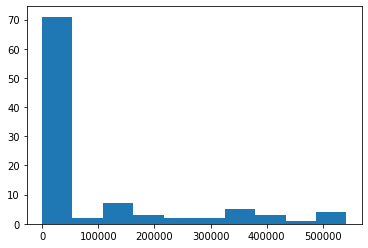

38


In [342]:
lenlist = [len(x) for x in markerized_list]
plt.hist(lenlist)
plt.show()
print(np.sum(np.asarray(lenlist)>10000))